In [82]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, KernelPCA, SparsePCA, TruncatedSVD
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, rand_score, homogeneity_score, completeness_score

In [14]:
%%time
!bcftools annotate --set-id '%CHROM\_%POS\_%REF\_%FIRST_ALT' /data/vcf/h3awgs/h3a_wgs.gtypes.vcf.gz -Oz -o input/h3a_wgs.vcf.gz 

CPU times: user 52.6 s, sys: 9.15 s, total: 1min 1s
Wall time: 59min 52s


In [15]:
%%time
!plink --vcf input/h3a_wgs.vcf.gz --indep-pairwise 100 20 0.2 --out input/prune/h3a_wgs

PLINK v1.90b7 64-bit (16 Jan 2023)             www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to input/prune/h3a_wgs.log.
Options in effect:
  --indep-pairwise 100 20 0.2
  --out input/prune/h3a_wgs
  --vcf input/h3a_wgs.vcf.gz

192825 MB RAM detected; reserving 96412 MB for main workspace.
--vcf: input/prune/h3a_wgs-temporary.bed + input/prune/h3a_wgs-temporary.bim +
input/prune/h3a_wgs-temporary.fam written.
36366490 variants loaded from .bim file.
386 people (0 males, 0 females, 386 ambiguous) loaded from .fam.
Ambiguous sex IDs written to input/prune/h3a_wgs.nosex .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 386 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total 

In [62]:
%%time
!plink --vcf input/h3a_wgs.vcf.gz --extract input/prune/h3a_wgs.prune.in --recode --out work/recode/h3a_wgs

PLINK v1.90b7 64-bit (16 Jan 2023)             www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to work/recode/h3a_wgs.log.
Options in effect:
  --extract input/prune/h3a_wgs.prune.in
  --out work/recode/h3a_wgs
  --recode
  --vcf input/h3a_wgs.vcf.gz

192825 MB RAM detected; reserving 96412 MB for main workspace.
--vcf: work/recode/h3a_wgs-temporary.bed + work/recode/h3a_wgs-temporary.bim +
work/recode/h3a_wgs-temporary.fam written.
36366490 variants loaded from .bim file.
386 people (0 males, 0 females, 386 ambiguous) loaded from .fam.
Ambiguous sex IDs written to work/recode/h3a_wgs.nosex .
--extract: 16697755 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 386 founders and 0 nonfounders present.
Calculating allele frequencies... 1011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374

In [63]:
%%time
!plink --file work/recode/h3a_wgs --make-bed --out work/binary/h3a_wgs --hwe 0.05 --maf 0.05

PLINK v1.90b7 64-bit (16 Jan 2023)             www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to work/binary/h3a_wgs.log.
Options in effect:
  --file work/recode/h3a_wgs
  --hwe 0.05
  --maf 0.05
  --make-bed
  --out work/binary/h3a_wgs

192825 MB RAM detected; reserving 96412 MB for main workspace.
.ped scan complete (for binary autoconversion).3131313141414151515151616161617171717181818181919191920202020212121222222222323232324242424252525252626262627272727282828292929293030303031313131323232323333333334343434353535363636363737373738383838393939394040404041414141424242434343434444444445454545464646464747474748484848494949505050505151515152525252535353535454545455555555565656565757575858585859595959606060606161616162626262636363636464646565656566666666676767676868686869696969707070707171717272727273737373747474747575757576767676777777777878787979797980808080818181818282828283838383848484848585858686868687878787888

In [64]:
%%time
!smartpca -p parfile.txt > output/pca/logfile

CPU times: user 40.6 s, sys: 5.99 s, total: 46.5 s
Wall time: 42min 36s


In [65]:
vec = pd.read_table('output/pca/h3a_wgs.evec', header=None, sep='\s+', engine='python', skiprows=1)
vec.head()

,0,1,2,3,4,5
0,H3A-7C44F2:H3A-7C44F2,0.0302,0.0598,0.0981,-0.0109,???
1,H3A-B4DD3C:H3A-B4DD3C,0.0218,0.0652,0.0721,-0.0107,???
2,H3A-31F23C:H3A-31F23C,0.0648,-0.0210,0.0498,0.1005,???
3,H3A-D3A6FE:H3A-D3A6FE,0.1479,-0.0104,-0.0553,-0.0381,???
4,H3A-0BF47F:H3A-0BF47F,0.0332,0.0600,0.1080,-0.0201,???


In [66]:
vec.iloc[:,0] = vec.iloc[:,0].map(lambda x: str(x).split(':')[0])
vec.head()

,0,1,2,3,4,5
0,H3A-7C44F2,0.0302,0.0598,0.0981,-0.0109,???
1,H3A-B4DD3C,0.0218,0.0652,0.0721,-0.0107,???
2,H3A-31F23C,0.0648,-0.0210,0.0498,0.1005,???
3,H3A-D3A6FE,0.1479,-0.0104,-0.0553,-0.0381,???
4,H3A-0BF47F,0.0332,0.0600,0.1080,-0.0201,???


In [67]:
meta = pd.read_table('/data/vcf/h3awgs/samples.meta.tsv', index_col='SampleID')
meta.head()

,Country,EthnolinguisticGroup,Gender,PI,Project,sourcefile
SampleID,,,,,,
H3A-7C44F2,Guinea,Guinea,Female,Fowler,Trypanogen,Trypanogen.tsv
H3A-B4DD3C,Cote D'Ivoire,Cote D'Ivoire,Male,Fowler,Trypanogen,Trypanogen.tsv
H3A-31F23C,Uganda,Uganda,Female,Fowler,Trypanogen,Trypanogen.tsv
H3A-D3A6FE,Uganda,Uganda,Female,Fowler,Trypanogen,Trypanogen.tsv
H3A-0BF47F,Guinea,Guinea,Male,Fowler,Trypanogen,Trypanogen.tsv


In [68]:
meta_dict = meta.iloc[:,[0]].to_dict()
countries = meta_dict.get('Country')
vec.iloc[:,5] =  vec.iloc[:,0].map(lambda x: countries.get(x))
vec.head()

,0,1,2,3,4,5
0,H3A-7C44F2,0.0302,0.0598,0.0981,-0.0109,Guinea
1,H3A-B4DD3C,0.0218,0.0652,0.0721,-0.0107,Cote D'Ivoire
2,H3A-31F23C,0.0648,-0.0210,0.0498,0.1005,Uganda
3,H3A-D3A6FE,0.1479,-0.0104,-0.0553,-0.0381,Uganda
4,H3A-0BF47F,0.0332,0.0600,0.1080,-0.0201,Guinea


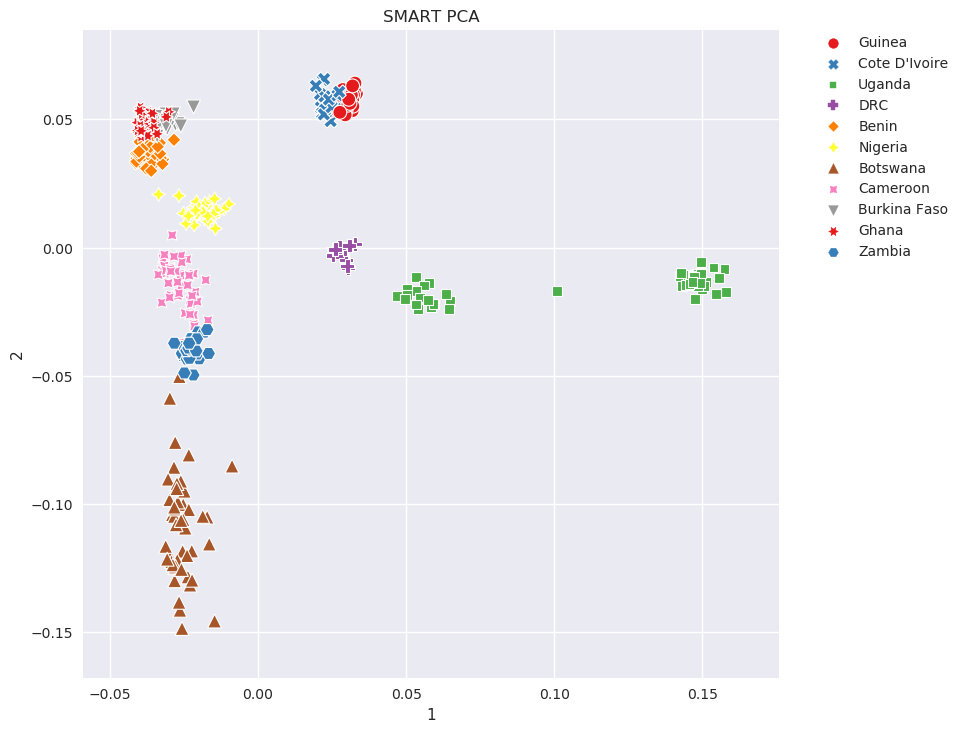

CPU times: user 1.59 s, sys: 257 ms, total: 1.84 s
Wall time: 1.64 s


In [136]:
%%time
plt.style.use("seaborn")
plt.figure(figsize=(8, 8))

ped_pca_plot = sns.scatterplot(
    x=vec.iloc[:,1],
    y=vec.iloc[:,2] ,
    data=vec, 
    hue=vec.iloc[:,5], 
    style=vec.iloc[:,5],
    palette="Set1",
    s=100
    )
ped_pca_plot.set_title('SMART PCA')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0) 
plt.savefig('output/plots/smart_pca.png', bbox_inches='tight')
plt.show()

In [133]:
kmeans = KMeans(
    n_clusters=5,
    init="k-means++",
    n_init=50,
    max_iter=500,
    random_state=42,
).fit(vec.iloc[:,[1,2]])
labels = kmeans.labels_
clusters = pd.DataFrame(kmeans.transform(vec.iloc[:,[1,2]]))
clusters[[5]] = pd.DataFrame(labels).values
clusters[[6]] = vec[[5]].values
clusters.head()

,0,1,2,3,4,5,6
0,0.030938,0.099885,0.137913,0.180060,0.065676,0,Guinea
1,0.038233,0.100205,0.147898,0.182850,0.060714,0,Cote D'Ivoire
2,0.058557,0.090135,0.082897,0.127814,0.109329,0,Uganda
3,0.119997,0.173683,0.002697,0.200714,0.183215,2,Uganda
4,0.030853,0.101746,0.135482,0.181201,0.068513,0,Guinea


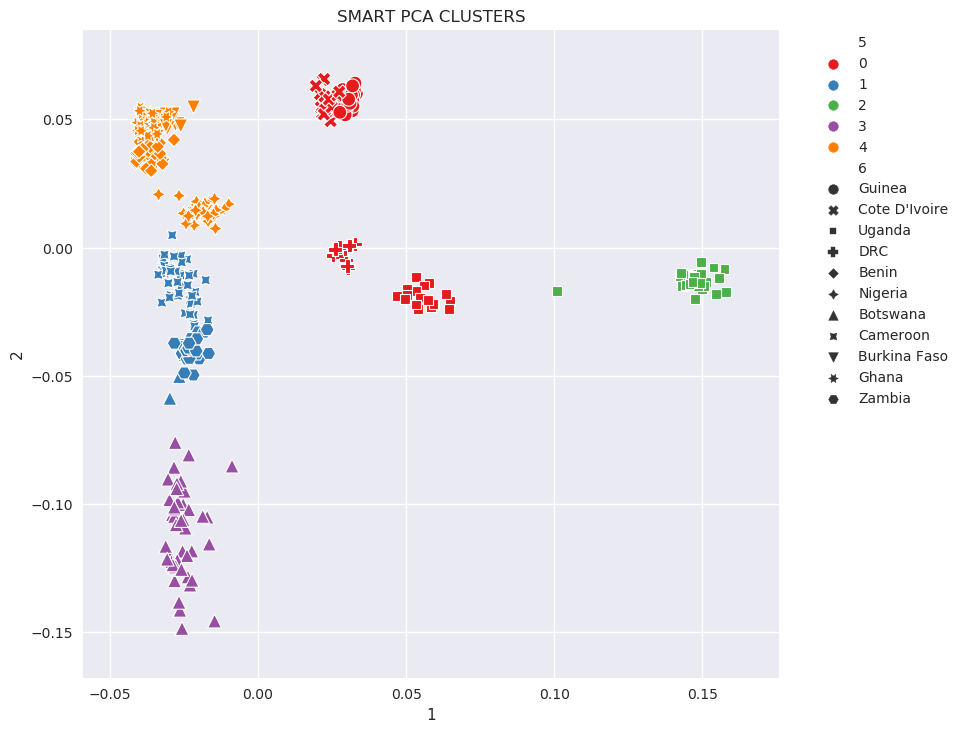

In [137]:
plt.style.use("seaborn")
plt.figure(figsize=(8, 8))

ped_cluster_plot = sns.scatterplot(
    x=vec.iloc[:,1],
    y=vec.iloc[:,2] ,
    data=vec, 
    hue=clusters.iloc[:,5], 
    style=clusters.iloc[:,6],
    palette="Set1",
    s=100
    )
ped_cluster_plot.set_title('SMART PCA CLUSTERS')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0) 
plt.savefig('output/plots/smart_pca_clusters.png', bbox_inches='tight')
plt.show()

In [135]:
print(f'Silhouette Scores:\t{silhouette_score(clusters[[0,1,2,3,4]], labels):.2f}')

Silhouette Scores:	0.64


In [32]:
%%bash
for country in $(less /data/vcf/h3awgs/samples.meta.tsv | cut -f 2 |sort | uniq | tr ' ' '_')
do 
count=$(echo $country | tr '_' ' ')
grep "$count" /data/vcf/h3awgs/samples.meta.tsv | cut -f 1 > "countries/${count}.txt" 
done


In [1]:
%%bash
for country in `ls countries | tr ' ' '_'`
do 
count=$(echo "${country}" | cut -d '.' -f1 )
name=`echo $country | tr '_' ' '`
echo Now Filtering $count
bcftools view -Ov -o "tmp/${count}_h3a.vcf" -S "countries/${name}" ../plink/tmp/h3a_wgs.gtypes.ids.vcf.gz &
done